### Implementation of the efficient algorithm for generating ROC points
- Algorithm 1 in paper by *Fawcett 2006*

In [1]:
# import necessary modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
def ROC_points(in_data):
    '''
    Function to generate ROC points for a bianry classifier on a given sample set with true lables and scores
    Input: a DataFrame with actual class label and scores
    Output:ROC points (tp rate, fp rate)
    '''
    ## sort the input data in descending order
    dat=in_data.sort_values(by=['score'],ascending=False)
    ## compute # of positive labels and negative labels
    P=dat.label[dat.label==1].count()
    N=dat.label[dat.label==0].count()
    
    ## initialize tp and fp to 0
    tp=0
    fp=0
    ## initialize previous score to -inf
    f_prev=-np.inf
    
    ## create an empty stack
    result=[]
    
    ## compute ROC points increasing by fp rate
    for i in range(dat.shape[0]):
        if dat.score[i]!=f_prev:
            result.append((fp/N,tp/P))
            f_prev=dat.score[i]
        if dat.label[i]==1:
            tp+=1
        else:
            fp+=1
    result.append((fp/N,tp/P))
    
    return pd.DataFrame(result,columns=['fp','tp'])

In [3]:
# test sample
# Figure 3 in Fawcett 2006
# class label=1: positive, label=0: negative
instance=np.array(range(20))
class_lable=np.array([1,1,0,1,1,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0])
score_=np.array([0.9,0.8,0.7,0.6,0.55,0.54,0.53,0.52,0.51,0.505,0.4,0.39,0.38,0.37,0.36,0.35,0.34,0.33,0.30,0.1])
temp={'ID':instance,'label':class_lable,'score':score_}

# put them together as a matrix
dat_test=pd.DataFrame(data=temp,index=range(len(instance)),columns=['ID','label','score'])


In [4]:
# shuffle the order
ind=np.random.choice(range(len(instance)),size=len(instance),replace=False)
dat_test=dat_test.iloc[ind]

In [5]:
#ind_order=np.argsort()
dat_test.sort_values(by=['score'],ascending=False)

,ID,label,score
0,0,1,0.900
1,1,1,0.800
2,2,0,0.700
3,3,1,0.600
4,4,1,0.550
5,5,1,0.540
6,6,0,0.530
7,7,0,0.520
8,8,1,0.510
9,9,0,0.505


In [6]:
points=ROC_points(dat_test)
points.head()

,fp,tp
0,0.0,0.0
1,0.0,0.1
2,0.0,0.2
3,0.1,0.2
4,0.1,0.3


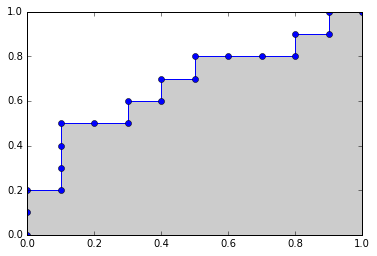

In [7]:
fig, ax = plt.subplots()
# plot the roc curve
plt.plot(points.fp,points.tp,'o-')
# shape the area under curve
verts =  [(points.fp[0], 0)]+list(zip(points.fp,points.tp))+[(points.fp[len(points.fp)-1], 0)]
poly = plt.Polygon(verts, facecolor='0.8', edgecolor='0.5')
ax.add_patch(poly)

In [8]:
def roc_graph(input_rates,title):
    '''
    Function to plot the ROC curve and the shaded the area under the curve
    input rates: the ROC points of a classification result
    return: None, plot is generated
    '''
    # import necessary packages
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    points=input_rates
    
    fig, ax = plt.subplots()
    # plot the roc curve
    plt.plot(points.fp,points.tp,'o-')
    
    # set axis labels and title
    plt.xlabel('False positive rate',fontsize=15)
    plt.ylabel('True positive rate',fontsize=15)
    plt.title(title,fontsize=20)
    
    # shape the area under curve
    verts =  [(points.fp[0], 0)]+list(zip(points.fp,points.tp))+[(points.fp[len(points.fp)-1], 0)]
    poly = plt.Polygon(verts, facecolor='0.8', edgecolor='0.5')
    ax.add_patch(poly)

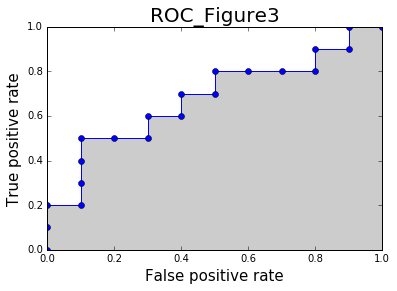

In [9]:
roc_graph(points,'ROC_Figure3')

## ROC curve averaging

When cross validation is done and clustering result of multiple test data sets are obtained, one might want to get a combined information on all the tested data sets-averaging multiple ROC curves. There are two ways of averaging multiple ROC curves:

- Verticle averaging: Algorithm 3 in paper by _Fawcett 2006_
- Threshold averaging: Algorithm 4 in paper by _Fawcett 2006_


### Verticle averaging

In [10]:
points.tp[1]-points.ix[2].tp

-0.10000000000000001

In [11]:
points.shape[0]

21

In [22]:
def INTERPOLATE(ROCP1,ROCP2,X):
    '''
    Function to compute the slope for interpolation
    Input: two ROC curve points(ROCP1,ROCP2)
           false postivie rates of false positive samples
    Return: 
    '''
    
    slope=(ROCP2.tp-ROCP1.tp)/(ROCP2.fp-ROCP1.fp)
    return ROCP1.tp+slope*(X-ROCP1.fp)

In [13]:
def TPR_FOR_FPR(fpr_sample,ROC,npts):
    '''
    '''
    i=1
    while(i<npts and ROC.fp[i] <= fpr_sample):
        i+=1
    
    if ROC.fp[i-1]==fpr_sample:
        return ROC.tp[i-1]
    else:
        return INTERPOLATE(ROC.ix[i-1],ROC.ix[i],fpr_sample)

In [18]:
l1=[points,points,points]
for i in l1:
    print(i.shape)

(21, 2)
(21, 2)
(21, 2)


In [14]:
# figure out input and ROC[i]

In [40]:
def verticle_averaging(sample,ROCS,*karg):
    '''
    Function to compute the verticle averaging ROC points for input points of ROC curves
    Input:sample(number of false positive samples, the number of points along the x axis of the averaged ROC curve),
          ROCS(a list of multiple ROC curves, each curve is  stored in DataFrame and has 2 components:fp and tp)
    Output: the averaged ROC curve
    '''

    # create an empty array to record result
    result=[]
    # number of roc cruves
    nrocs=len(ROCS)
    
    for fpr_sample in np.arange(0,(1+1/sample),1/sample):
        tprsum=0
        for i in range(nrocs):
            tprsum+=TPR_FOR_FPR(fpr_sample,ROCS[i],ROCS[i].shape[0])
        result.append((fpr_sample,tprsum/nrocs))
    #result.append((1,1))
    return pd.DataFrame(result,columns=['fp','tp'])

In [43]:
verticle_averaging(10,l1)

,fp,tp
0,0.0,0.2
1,0.1,0.5
2,0.2,0.5
3,0.3,0.6
4,0.4,0.7
5,0.5,0.8
6,0.6,0.8
7,0.7,0.8
8,0.8,0.9
9,0.9,1.0


In [26]:
points

,fp,tp
0,0.0,0.0
1,0.0,0.1
2,0.0,0.2
3,0.1,0.2
4,0.1,0.3
5,0.1,0.4
6,0.1,0.5
7,0.2,0.5
8,0.3,0.5
9,0.3,0.6


### Threshold averaging 